# AR/MA processes as as state-space models

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## AR(m) process

A time series $y_{1:t}$ is said to be a $m$-th order moving average (MA) process
if there are known $p\,\times\,p$ matrices $A_1, \ldots, A_m$ such that
$$
    y_t = \sum_{j=1}^m A_{t-j}\,e_j + e_t
$$

In state-space form, the AR(m) process is given by
$$
    {\bf z}_t =
    {\bf F}_\text{AR}{\bf z}_{t-1} + {\bf u}_t
$$

with
$$
    {\bf F}_\text{AR} =
    \begin{bmatrix}
    {\bf 0} & {\bf 0} & \ldots & {\bf 0} & {\bf 0}\\
    {\bf 0} & {\bf I} & \ldots & {\bf 0} & {\bf 0} \\
    {\bf 0} & {\bf 0} & \ldots & {\bf I} & {\bf 0}
    \end{bmatrix}
$$

and ${\bf u}_t = {\bf T}_m\,{\bf e}_t$ for ${\bf T}_m$ given by
$$
    {\bf T}_m =
    \begin{bmatrix}
    {\bf I}\\
    {\bf 0} \\
    \vdots \\
    {\bf 0}
    \end{bmatrix}
$$

### Building blocks

In [68]:
Fma = jnp.r_[
    jnp.zeros((1,2)),
    jnp.eye(2)
]
Fma = jnp.c_[Fma, jnp.zeros(3)]
Fma

Array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [72]:
Tm = jnp.zeros((3,1)).at[0].set(1)
Tm

Array([[1.],
       [0.],
       [0.]], dtype=float32)

In [73]:
Fma

Array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

### Sampling

In [75]:
key = jax.random.PRNGKey(314)

In [85]:
A = jnp.array([[0.2, 0.3, -0.5]])

In [109]:
def step(x, key):
    et = jax.random.normal(key, (1,1)) * w0
    y = A @ x + et # y(t)
    z = Fma @ x + Tm @ et # z(t+1)

    out = {
        "y": y,
        "z": z
    }
    
    return z, out

In [130]:
n_samples = 50

In [131]:
w0 = 0.1 ** 2 # measurement noise
z0 = jnp.zeros((3,1))

In [132]:
keys = jax.random.split(key, n_samples)
_, hist = jax.lax.scan(step, z0, keys)
hist = jax.tree.map(jnp.squeeze, hist)

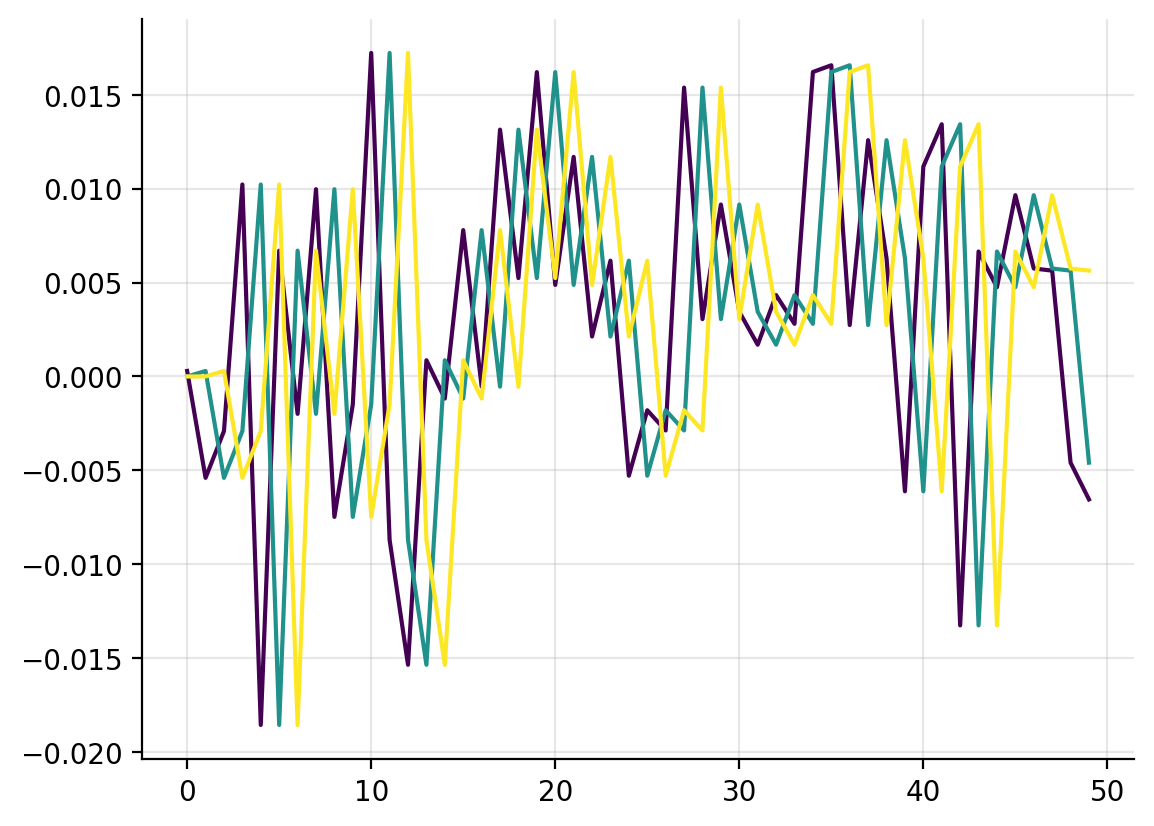

In [133]:
colors = plt.cm.viridis(jnp.linspace(0, 1, 3))
for i, color in enumerate(colors):
    plt.plot(hist["z"][:, i], color=color)
plt.grid(alpha=0.3)

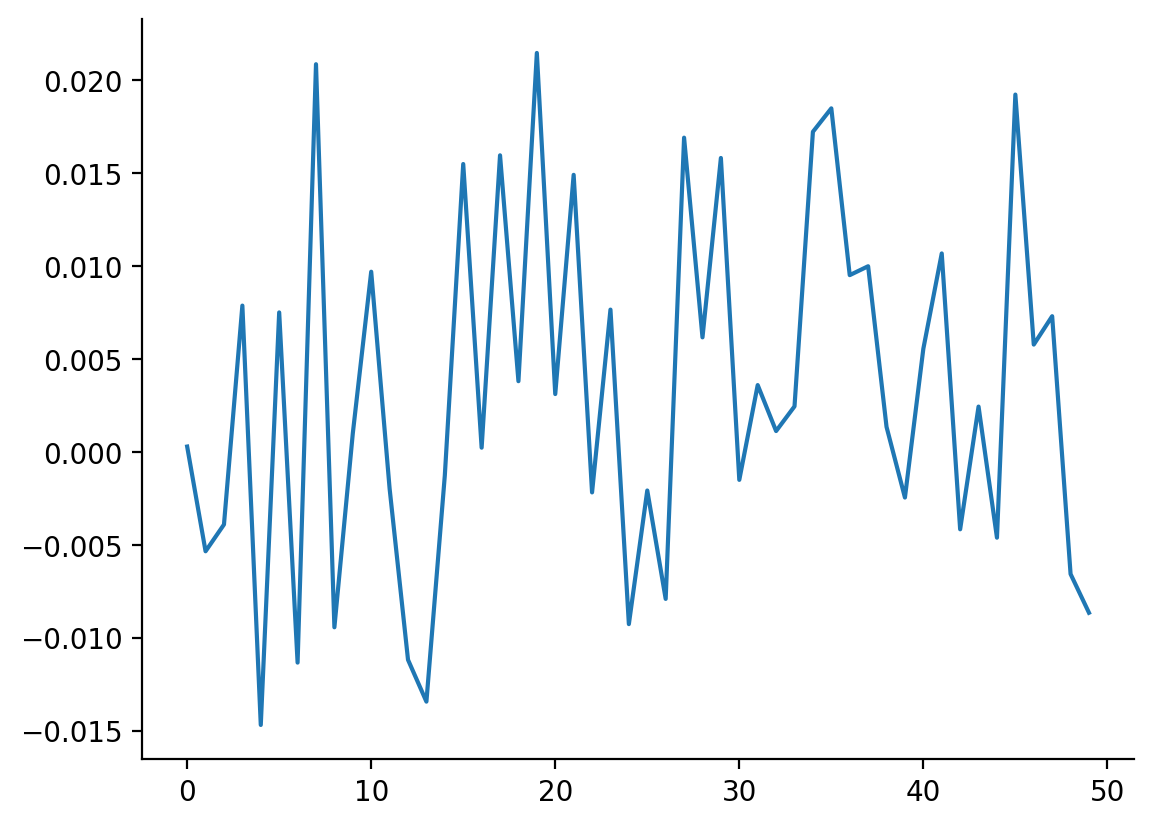

In [134]:
plt.plot(hist["y"])